# Import files

In [1]:
import pandas as pd

from preprocessing import (
    read_csv_files, filter_nodes, convert_dates_to_datetime,
    add_holidays,add_weather_data,set_indexes_for_timeseries,
    get_train_test,fill_missing_values
)

DATA_DIR = './data'
filenames = ['champs-elysees.csv', 'convention.csv', 'saints-peres.csv']
dfs = read_csv_files(DATA_DIR, filenames)
TIME_WINDOW = 14
df = pd.concat(dfs)
df_filtered = filter_nodes(df)
df_filtered = df_filtered.drop(['Libelle noeud amont','Libelle noeud aval'],axis=1)
df_filtered['Jour de la semaine'] = pd.to_datetime(df_filtered["Date et heure de comptage"]).dt.dayofweek
df_filtered = pd.concat([
    df_filtered,
    pd.get_dummies(df_filtered['Jour de la semaine'],prefix='Jour de la semaine')
], axis=1).drop(columns=['Jour de la semaine'])

df_filtered.sample(10)
df_filtered['Date'] = pd.to_datetime(df_filtered["Date et heure de comptage"]).dt.date
add_holidays(df_filtered,DATA_DIR)
df_filtered = add_weather_data(df_filtered,DATA_DIR)

traffic_state_encoding = {"Inconnu":0, "Fluide":1, "Pré-saturé":2, "Saturé":3, "Bloqué":4}
df_filtered["Etat trafic"] = df_filtered["Etat trafic"].map(traffic_state_encoding)
df_train, df_test = get_train_test(df_filtered)

df_train_ce = df_train[df_train['filename']=='champs-elysees.csv']
df_train_sts = df_train[df_train['filename']=='saints-peres.csv']
df_train_conv = df_train[df_train['filename']=='convention.csv']

df_test_ce = df_test[df_test['filename']=='champs-elysees.csv']
df_test_sts = df_test[df_test['filename']=='saints-peres.csv']
df_test_conv = df_test[df_test['filename']=='convention.csv']

dfs_train = [df_train_ce,df_train_sts,df_train_conv]
dfs_test = [df_test_ce,df_test_sts,df_test_conv]


df_ = dfs_train[0]

date_time = df_['Date et heure de comptage']
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
week = 7*day

import numpy as np
df_['daySin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_['weekSin'] = np.sin(timestamp_s * (2 * np.pi / week))

/var/folders/m8/sb3p17zj07s4h28sd6njtsbw0000gn/T/ipykernel_37169/1376128401.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['daySin'] = np.sin(timestamp_s * (2 * np.pi / day))
/var/folders/m8/sb3p17zj07s4h28sd6njtsbw0000gn/T/ipykernel_37169/1376128401.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['weekSin'] = np.sin(timestamp_s * (2 * np.pi / week))


## Check for messy columns

In [2]:
analysis_df_ = df_.select_dtypes(include='object').applymap(lambda x: not(np.isreal(x)))
analysis_df_.all(axis=0)


Libelle                   True
Etat arc                  True
Date debut dispo data     True
Date fin dispo data       True
geo_point_2d              True
geo_shape                 True
filename                  True
Date                     False
moonrise                 False
moonset                  False
sunrise                  False
sunset                   False
location                 False
dtype: bool

In [3]:
df_.columns

Index(['Libelle', 'Date et heure de comptage', 'Débit horaire',
       'Taux d'occupation', 'Etat trafic', 'Identifiant noeud amont',
       'Identifiant noeud aval', 'Etat arc', 'Date debut dispo data',
       'Date fin dispo data', 'geo_point_2d', 'geo_shape', 'filename',
       'Jour de la semaine_0', 'Jour de la semaine_1', 'Jour de la semaine_2',
       'Jour de la semaine_3', 'Jour de la semaine_4', 'Jour de la semaine_5',
       'Jour de la semaine_6', 'Date', 'Jour férié', 'Vacances scolaires',
       'Prochaines vacances scolaires',
       'Durée avant les prochaines vacances scolaires', 'maxtempC', 'mintempC',
       'totalSnow_cm', 'sunHour', 'uvIndex', 'moon_illumination', 'moonrise',
       'moonset', 'sunrise', 'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph',
       'location', 'daySin', 'weekSin'],
      dtype='object')

In [4]:
outcomes = ["Débit horaire","Taux d'occupation"]  # does he die or not

df_y = df_.loc[:, outcomes]
df_x = df_.loc[:, [k for k in df_.columns if k not in outcomes]]

In [5]:
from IPython.display import Markdown


def warning_(warning_list):
    if warning_list:
        flag = ", ".join(warning_list)
        display(
            Markdown(
                'Frozen features {} are not in line with this test.'.format(
                    flag
                )
            )
        )
    else:
        display(Markdown('All of the covariates passed the test'))

## Columns with too many missing values

Text(0.5, 1.0, 'Number of features depending on perc val')

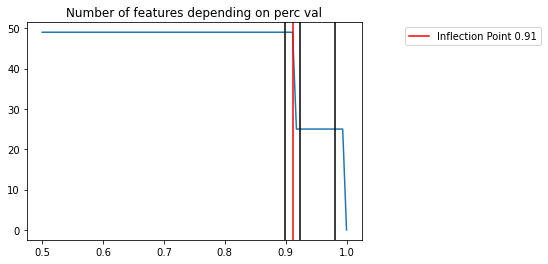

In [6]:
import matplotlib.pyplot as plt

df_valid_count = df_x.count()

x, y = np.linspace(0.5, 1, 80), [
    (df_valid_count > threshold * df_valid_count.max()).sum()
    for threshold in np.linspace(0.5, 1, 80)
]

plt.plot(x, y)

# compute second derivative
y_d2 = np.gradient(np.gradient(y))
# find switching points
infls = np.where(np.diff(np.sign(y_d2)))[0]
# plot results
for i, infl in enumerate(infls, 1):

    plt.axvline(
        x=x[infl],
        color="k" if i != len(infls) // 2 else "red",
        label="Inflection Point {:.2f}".format(x[infl]) if i == len(infls) // 2 else None,
    )
plt.legend(bbox_to_anchor=(1.55, 1.0))

plt.title("Number of features depending on perc val")

In [7]:
reject_list = {}

In [10]:
keep_list_ = (df_valid_count > 0.84 * df_valid_count.max()).tolist()
col_ = [col for index, col in enumerate(list(df_x.columns)) if keep_list_[index]]
warning_([col for col in df_x.columns if col not in col_])
print("{} columns kept ouf of {}".format(len(col_), len(df_x.columns)))

reject_list["missing_values"] = [col for col in df_x.columns if col not in col_]
df_x = df_x.loc[:,col_]

All of the covariates passed the test

49 columns kept ouf of 49


## Features without variance

In [12]:
(df_x.loc[:,df_x.dtypes=="float64"].nunique()/len(df_x)).sort_values()

rate_lower_bound =  0

stat_ = ((df_x.nunique()/len(df_x))>rate_lower_bound)
select_ = [col for col in df_x.columns if stat_[col]]

select__ = [col for col in df_x.columns if col in select_]
print("{} columns kept ouf of {}".format(len(select__),len(df_x.columns)))

warning_([col for col in select__ if col not in select_])

reject_list["unique_values"] = [col for col in select__ if col not in select_]
df_x = df_x[select__]

49 columns kept ouf of 49


All of the covariates passed the test

## Remove features with a  major part of fucking same values (not usable for ML models)

In [14]:
rate_lower_bound = 0.4

filtered_columns_ = [
    col
    for col in df_x.columns
    if df_x[col].value_counts().max() / len(df_x)
    < rate_lower_bound
]
warning_([col for col in df_x if col not in filtered_columns_])

# filter_history['repeated_values'] = set([col for col in df_x if col not in filtered_columns__])
print("{} features kept out of {}".format(len(filtered_columns_), len(df_x.columns)))


reject_list["repeated_values"] = [col for col in df_x if col not in filtered_columns_]
df_x = df_x.loc[:, filtered_columns_]

Frozen features Libelle, Identifiant noeud amont, Identifiant noeud aval, Etat arc, Date debut dispo data, Date fin dispo data, geo_point_2d, geo_shape, filename, Jour de la semaine_0, Jour de la semaine_1, Jour de la semaine_2, Jour de la semaine_3, Jour de la semaine_4, Jour de la semaine_5, Jour de la semaine_6, Jour férié, Vacances scolaires, totalSnow_cm, precipMM, visibility, location are not in line with this test.

27 features kept out of 49


## Corr pre analysis (linear correlation) 

In [15]:
import numpy as np

take = 15

corr_matrix = df_x.corr().abs()

# the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)

sol = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    .stack()
    .sort_values(ascending=False)
)
print(f"Top {take} correlated features \t\t     Pearson")
print(sol[:take])

Top 15 correlated features 		     Pearson
FeelsLikeC    WindChillC       0.998158
HeatIndexC    tempC            0.996388
WindChillC    tempC            0.994656
FeelsLikeC    HeatIndexC       0.993660
HeatIndexC    WindChillC       0.992187
FeelsLikeC    tempC            0.992018
maxtempC      uvIndex          0.950099
WindGustKmph  windspeedKmph    0.945790
maxtempC      mintempC         0.911785
              WindChillC       0.894465
              FeelsLikeC       0.894067
              HeatIndexC       0.884632
              tempC            0.884573
mintempC      FeelsLikeC       0.879642
              WindChillC       0.876777
dtype: float64


/var/folders/m8/sb3p17zj07s4h28sd6njtsbw0000gn/T/ipykernel_37169/3718950027.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


## Entropy analysis for correlation (general correlation)

In [44]:
from analysisTool import pipeline

result, merits = pipeline(df_x.drop(["Date", "Etat trafic"], axis=1), df_y)
result, merits

/Users/arnaudpetit/Documents/Programmation/3A/datathon_gamma_livraisonCO/analysisTool/CFS_greedy/pipeline_cfs.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,proc_col] = df[proc_col].replace(bijectiv_hasher).astype("int32")


(['moonrise',
  'Durée avant les prochaines vacances scolaires',
  'Date et heure de comptage',
  'moonset',
  'weekSin',
  'humidity',
  'sunset',
  'daySin',
  'cloudcover',
  'winddirDegree',
  'sunrise'],
 array([0.28451152, 0.32012362, 0.32742999, 0.33553436, 0.34263905,
        0.34217626, 0.3417722 , 0.34111321, 0.34080971, 0.33962932,
        0.3385712 ]))

## Ridge regression for sensitivity

In [62]:
df_x_ml = df_x.copy()
index = ~df_x_ml.isna().any(axis=1)
df_x_ml, df_y_ml =  df_x_ml[index], df_y[index]

index = ~df_y_ml.isna().any(axis=1)
df_x_ml, df_y_ml =  df_x_ml[index], df_y_ml[index]

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_x_ml = df_x_ml.select_dtypes(include=numerics)


MAX_EPOCHS = 200
from sklearn.model_selection import train_test_split

import tensorflow as tf

list_drop = []#["apache_4a_icu_death_prob", "apache_4a_hospital_death_prob", "d1_calcium_min", "d1_calcium_max"]


X, X_test, y, y_test = train_test_split(
    df_x_ml, df_y_ml, test_size=0.3, shuffle=True
)

X = (X - X.mean()) / X.std()
X_test = (X_test - X.mean()) / X_test.std()


def compile_and_fit(model, x_train, y_train, x_val, y_val, patience=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=64,
        #validation_data=(x_val, y_val),
        epochs=MAX_EPOCHS,
        callbacks=[early_stopping],
    )
    return history


linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])
history = compile_and_fit(linear, X, y, X_test, y_test)

Epoch 1/200
80/80 [==============================] - 1s 2ms/step - loss: 428373.7500 - mean_absolute_error: 442.6125
Epoch 2/200
80/80 [==============================] - 0s 4ms/step - loss: 428260.2188 - mean_absolute_error: 442.5299
Epoch 3/200
80/80 [==============================] - 0s 3ms/step - loss: 428148.9688 - mean_absolute_error: 442.4475
Epoch 4/200
80/80 [==============================] - 0s 3ms/step - loss: 428039.5000 - mean_absolute_error: 442.3697
Epoch 5/200
80/80 [==============================] - 0s 2ms/step - loss: 427927.8438 - mean_absolute_error: 442.2869
Epoch 6/200
80/80 [==============================] - 0s 2ms/step - loss: 427817.5625 - mean_absolute_error: 442.2055
Epoch 7/200
80/80 [==============================] - 0s 3ms/step - loss: 427705.4062 - mean_absolute_error: 442.1257
Epoch 8/200
80/80 [==============================] - 0s 3ms/step - loss: 427596.5625 - mean_absolute_error: 442.0468
Epoch 9/200
80/80 [==============================] - 0s 3ms/step

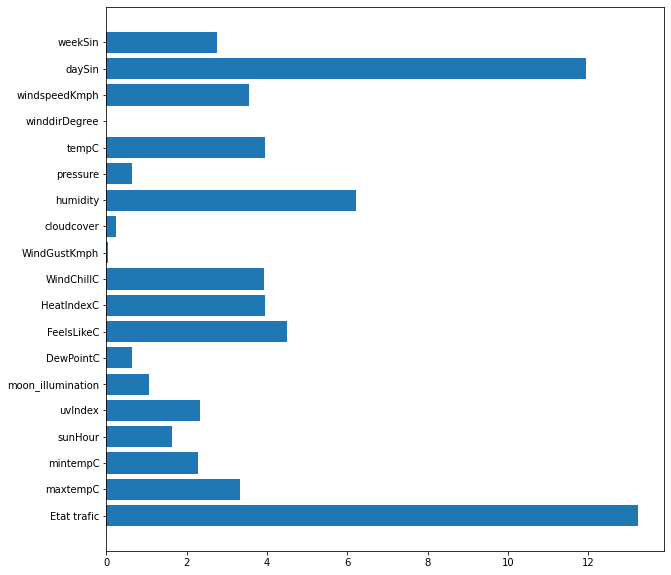

In [63]:
plt.rcParams['figure.figsize'] = [10, 10]

plt.barh(y = range(len(df_x_ml.drop(list_drop, axis=1).columns)),
        width=np.abs(linear.layers[0].kernel[:,0].numpy()))
axis = plt.gca()
axis.set_yticks(range(len(df_x_ml.drop(list_drop, axis=1).columns)))
_ = axis.set_yticklabels(df_x_ml.drop(list_drop, axis=1).columns)